Fator inicial = 1.000000
05-2020: variação = -0.3800%   |   fator acumulado = 0.996200
06-2020: variação = 0.2600%   |   fator acumulado = 0.998790
07-2020: variação = 0.3600%   |   fator acumulado = 1.002386
08-2020: variação = 0.2400%   |   fator acumulado = 1.004791
09-2020: variação = 0.6400%   |   fator acumulado = 1.011222
10-2020: variação = 0.8600%   |   fator acumulado = 1.019919
11-2020: variação = 0.8900%   |   fator acumulado = 1.028996
12-2020: variação = 1.3500%   |   fator acumulado = 1.042887
01-2021: variação = 0.2500%   |   fator acumulado = 1.045495
02-2021: variação = 0.8600%   |   fator acumulado = 1.054486
03-2021: variação = 0.9300%   |   fator acumulado = 1.064293
04-2021: variação = 0.3100%   |   fator acumulado = 1.067592
05-2021: variação = 0.8300%   |   fator acumulado = 1.076453
06-2021: variação = 0.5300%   |   fator acumulado = 1.082158
07-2021: variação = 0.9600%   |   fator acumulado = 1.092547
08-2021: variação = 0.8700%   |   fator acumulado = 1.10205

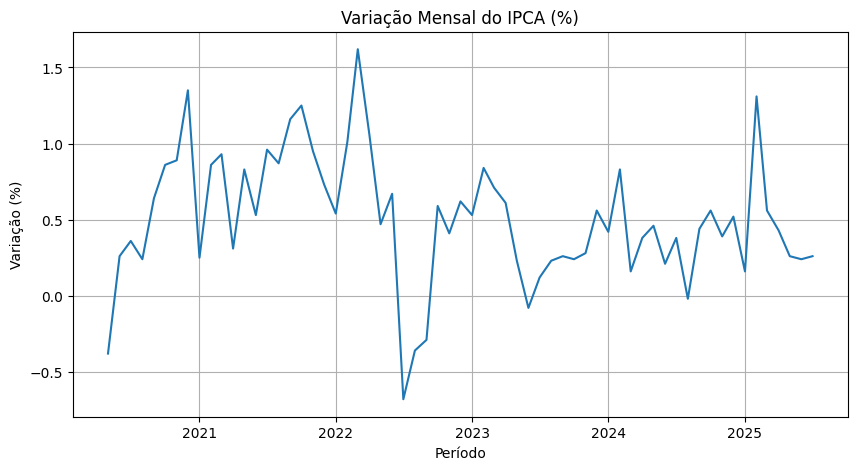

In [1]:
# --- imports ---
import ipeadatapy as ipea
import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st
from datetime import datetime

# --- Premissas para correção monetária considerando as datas ---
# 1970 até fev/1986 -> cruzeiro (Cr$) | cruzeiro para real fator de conversão = 1 / (1000^3 * 2750);
data_corte_cruzeiro = datetime(1986, 3, 1)
fator_cruzeiro_real = 1 / (1000**3 * 2750)
fator_real_cruzeiro = 1000**3 * 2750
# mar/1986 até jan/1989 -> cruzado (Cz$) | cruzado para real fator de conversão = 1 / (1000^2 * 2750);
data_corte_cruzado = datetime(1989, 2, 1)
fator_cruzado_real = 1 / (1000**2 * 2750)
fator_real_cruzado = 1000**2 * 2750
# fev/1989 até mar/1990 -> cruzado novo (NCz$) | cruzado novo para real fator de conversão = 1 / (1000 * 2750);
data_corte_cruzadonovo = datetime(1990, 4, 1)
fator_cruzadonovo_real = 1 / (1000 * 2750)
fator_real_cruzadonovo = 1000 * 2750
# abr/1990 até jul/1993 ->  cruzeiro (Cr$) | cruzeiro para real fator de conversão = 1 / (1000 * 2750);
data_corte_cruzeiro2 = datetime(1993, 8, 1)
fator_cruzeiro2_real = 1 / (1000 * 2750)
fator_real_cruzeiro2 = 1000 * 2750
# ago/1993 até jun/1994 -> cruzeiro real (CR$) | cruzeiro real para real fator de conversão = 1 / 2750;
data_corte_cruzeiroreal = datetime(1994, 7, 1)
fator_cruzeiroreal_real = 1 / 2750
fator_real_cruzeiroreal = 2750
# jul/1994 em diante -> real (R$)


# --- função para converter a data digitada ---
def parse_data(user_input):
    for fmt in ("%Y-%m", "%m-%Y"):
        try:
            return datetime.strptime(user_input, fmt)
        except ValueError:
            pass
    raise ValueError("Formato inválido. Use AAAA-MM ou MM-AAAA.")

# --- função para fazer a correção monetária considerando a inflação ---
def inflacao(periodo):
    fator = 1.0
    for data, variacao in periodo.items():
        fator = fator * (1 + variacao/100)
        print(
            f"{data.strftime('%m-%Y')}: "
            f"variação = {variacao:.4f}%   |   fator acumulado = {fator:.6f}"
        )
    return fator

# --- função para fazer a correção monetária considerando uma deflação ---
def deflacao(periodo, valor_data_inicial):
    denominador = 1.0
    fator_inicial = (1 + valor_data_inicial/100 ) 
    for data, variacao in periodo.items():
        denominador = (1 + variacao/100) * denominador
        fator = fator_inicial / denominador
        print(
            f"{data.strftime('%m-%Y')}: "
            f"variação = {variacao:.4f}%   |   fator deflacionado = {fator:.6f}" 
        )
    return fator


# --- código principal ---
IPCA = ipea.timeseries("PRECOS12_IPCAG12")

# datas válidas na série do IPCA
data_inicial_valida = min(IPCA.index).strftime("%m-%Y")
data_final_valida = max(IPCA.index).strftime("%m-%Y")

# pedir datas ao usuário
data_inicial = parse_data(input("Digite a data inicial (AAAA-MM ou MM-AAAA): "))
data_final   = parse_data(input("Digite a data final (AAAA-MM ou MM-AAAA): "))

# pedir o valor a ser corrigido
valor = float(input("Digite o valor a ser corrigido: "))

# garantir que no filtro, a função .loc consiga sempre pegar da menor data até a maior data
inicio = min(data_inicial, data_final)
fim = max(data_inicial, data_final)

# filtrar período (convertendo datetime para string ano-mês)
periodo = IPCA.loc[inicio.strftime("%Y-%m"):fim.strftime("%Y-%m"), "VALUE ((% a.m.))"]

# condições para as correções monetárias
if not (data_inicial in IPCA.index and data_final in IPCA.index):
    print(
        f"As datas digitadas não estão no período do índice IPCA."
        f"\nUtilize as datas entre {data_inicial_valida} até {data_final_valida}."
        f"\nObrigado. Vai corinthians!"
    )
elif data_inicial < data_final and data_inicial < data_corte_cruzeiro: # cruzeiro para real
    print(f"Fator inicial = 1.000000")
    fator = inflacao(periodo)
    valor_inflacao = (fator - 1) * 100
    valor_corrigido = valor * fator * fator_cruzeiro_real
    print(
        f"\nFator acumulado no período: {round(fator, 6)}"
        f"\nInflação no período foi de: {round(valor_inflacao,3)}%"
        f"\nValor nominal: Cr$ {valor}"
        f"\nValor corrigido: R$ {round(valor_corrigido, 2)}"
    )
elif data_inicial < data_final and data_inicial < data_corte_cruzado: # cruzado para real
    print(f"Fator inicial = 1.000000")
    fator = inflacao(periodo)
    valor_inflacao = (fator - 1) * 100
    valor_corrigido = valor * fator * fator_cruzado_real
    print(
        f"\nFator acumulado no período: {round(fator, 6)}"
        f"\nInflação no período foi de: {round(valor_inflacao,3)}%"
        f"\nValor nominal: Cz$ {valor}"
        f"\nValor corrigido: R$ {round(valor_corrigido, 2)}"
    )
elif data_inicial < data_final and data_inicial < data_corte_cruzadonovo: # cruzado novo para real
    print(f"Fator inicial = 1.000000")
    fator = inflacao(periodo)
    valor_inflacao = (fator - 1) * 100
    valor_corrigido = valor * fator * fator_cruzadonovo_real
    print(
        f"\nFator acumulado no período: {round(fator, 6)}"
        f"\nInflação no período foi de: {round(valor_inflacao,3)}%"
        f"\nValor nominal: NCz$ {valor}"
        f"\nValor corrigido: R$ {round(valor_corrigido, 2)}"
    )
elif data_inicial < data_final and data_inicial < data_corte_cruzeiro2: # volta do cruzeiro para real
    print(f"Fator inicial = 1.000000")
    fator = inflacao(periodo)
    valor_inflacao = (fator - 1) * 100
    valor_corrigido = valor * fator * fator_cruzeiro2_real
    print(
        f"\nFator acumulado no período: {round(fator, 6)}"
        f"\nInflação no período foi de: {round(valor_inflacao,3)}%"
        f"\nValor nominal: Cr$ {valor}"
        f"\nValor corrigido: R$ {round(valor_corrigido, 2)}"
    )
elif data_inicial < data_final and data_inicial < data_corte_cruzeiroreal: # cruzeiro real para real
    print(f"Fator inicial = 1.000000")
    fator = inflacao(periodo)
    valor_inflacao = (fator - 1) * 100
    valor_corrigido = valor * fator * fator_cruzeiroreal_real
    print(
        f"\nFator acumulado no período: {round(fator, 6)}"
        f"\nInflação no período foi de: {round(valor_inflacao,3)}%"
        f"\nValor nominal: CR$ {valor}"
        f"\nValor corrigido: R$ {round(valor_corrigido, 2)}"
    )
elif data_inicial < data_final and data_inicial >= data_corte_cruzeiroreal: # apenas correção monetária em real considerando a inflação
    print(f"Fator inicial = 1.000000")
    fator = inflacao(periodo)
    valor_inflacao = (fator - 1) * 100
    valor_corrigido = valor * fator
    print(
        f"\nFator acumulado no período: {round(fator, 6)}"
        f"\nInflação no período foi de: {round(valor_inflacao,3)}%"
        f"\nValor nominal: R$ {valor}"
        f"\nValor corrigido: R$ {round(valor_corrigido, 2)}"
    )
elif data_inicial > data_final and data_final < data_corte_cruzeiro: # real para cruzeiro
    valor_data_inicial = IPCA.loc[data_final.strftime("%Y-%m"), "VALUE ((% a.m.))"].values[0] # como a data final é menor que a data inicial, para fazer o cálculo do fator acumulado na função deflação é necessário utilizar a data final como valor da data inicial
    fator_inicial_deflacao = (1 + valor_data_inicial/100)
    print(f"Fator deflator inicial = {fator_inicial_deflacao:.6f}")
    fator = deflacao(periodo, valor_data_inicial)
    valor_deflacao = (1 - fator)*100
    valor_corrigido = valor * fator * fator_real_cruzeiro
    print(
        f"\nFator deflacionado no periodo: {round(fator, 6)}"
        f"\nDeflação no período foi de: {round(valor_deflacao, 3)}%"
        f"\nValor nominal: R$ {valor}"
        f"\nValor deflacionado: Cr$ {round(valor_corrigido, 2)}"
    )
elif data_inicial > data_final and data_final < data_corte_cruzado: # real para cruzado
    valor_data_inicial = IPCA.loc[data_final.strftime("%Y-%m"), "VALUE ((% a.m.))"].values[0] # como a data final é menor que a data inicial, para fazer o cálculo do fator acumulado na função deflação é necessário utilizar a data final como valor da data inicial
    fator_inicial_deflacao = (1 + valor_data_inicial/100)
    print(f"Fator deflator inicial = {fator_inicial_deflacao:.6f}")
    fator = deflacao(periodo, valor_data_inicial)
    valor_deflacao = (1 - fator)*100
    valor_corrigido = valor * fator * fator_real_cruzado
    print(
        f"\nFator deflacionado no periodo: {round(fator, 6)}"
        f"\nDeflação no período foi de: {round(valor_deflacao, 3)}%"
        f"\nValor nominal: R$ {valor}"
        f"\nValor deflacionado: Cz$ {round(valor_corrigido, 2)}"
    )
elif data_inicial > data_final and data_final < data_corte_cruzadonovo: # real para cruzado novo
    valor_data_inicial = IPCA.loc[data_final.strftime("%Y-%m"), "VALUE ((% a.m.))"].values[0] # como a data final é menor que a data inicial, para fazer o cálculo do fator acumulado na função deflação é necessário utilizar a data final como valor da data inicial
    fator_inicial_deflacao = (1 + valor_data_inicial/100)
    print(f"Fator deflator inicial = {fator_inicial_deflacao:.6f}")
    fator = deflacao(periodo, valor_data_inicial)
    valor_deflacao = (1 - fator)*100
    valor_corrigido = valor * fator * fator_real_cruzadonovo
    print(
        f"\nFator deflacionado no periodo: {round(fator, 6)}"
        f"\nDeflação no período foi de: {round(valor_deflacao, 3)}%"
        f"\nValor nominal: R$ {valor}"
        f"\nValor deflacionado: NCz$ {round(valor_corrigido, 2)}"
    )
elif data_inicial > data_final and data_final < data_corte_cruzeiro2: # real para volta do cruzeiro
    valor_data_inicial = IPCA.loc[data_final.strftime("%Y-%m"), "VALUE ((% a.m.))"].values[0] # como a data final é menor que a data inicial, para fazer o cálculo do fator acumulado na função deflação é necessário utilizar a data final como valor da data inicial
    fator_inicial_deflacao = (1 + valor_data_inicial/100)
    print(f"Fator deflator inicial = {fator_inicial_deflacao:.6f}")
    fator = deflacao(periodo, valor_data_inicial)
    valor_deflacao = (1 - fator)*100
    valor_corrigido = valor * fator * fator_real_cruzeiro2
    print(
        f"\nFator deflacionado no periodo: {round(fator, 6)}"
        f"\nDeflação no período foi de: {round(valor_deflacao, 3)}%"
        f"\nValor nominal: R$ {valor}"
        f"\nValor deflacionado: Cr$ {round(valor_corrigido, 2)}"
    )
elif data_inicial > data_final and data_final < data_corte_cruzeiroreal: # real para cruzeiro real
    valor_data_inicial = IPCA.loc[data_final.strftime("%Y-%m"), "VALUE ((% a.m.))"].values[0] # como a data final é menor que a data inicial, para fazer o cálculo do fator acumulado na função deflação é necessário utilizar a data final como valor da data inicial
    fator_inicial_deflacao = (1 + valor_data_inicial/100)
    print(f"Fator deflator inicial = {fator_inicial_deflacao:.6f}")
    fator = deflacao(periodo, valor_data_inicial)
    valor_deflacao = (1 - fator)*100
    valor_corrigido = valor * fator * fator_real_cruzeiroreal
    print(
        f"\nFator deflacionado no periodo: {round(fator, 6)}"
        f"\nDeflação no período foi de: {round(valor_deflacao, 3)}%"
        f"\nValor nominal: R$ {valor}"
        f"\nValor deflacionado: Cr$ {round(valor_corrigido, 2)}"
    )
elif data_inicial > data_final and data_final >= data_corte_cruzeiroreal: # apenas correção monetária em real considerando a deflação
    valor_data_inicial = IPCA.loc[data_final.strftime("%Y-%m"), "VALUE ((% a.m.))"].values[0] # como a data final é menor que a data inicial, para fazer o cálculo do fator acumulado na função deflação é necessário utilizar a data final como valor da data inicial
    fator_inicial_deflacao = (1 + valor_data_inicial/100)
    print(f"Fator deflator inicial = {fator_inicial_deflacao:.6f}")
    fator = deflacao(periodo, valor_data_inicial)
    valor_deflacao = (1 - fator)*100
    valor_corrigido = valor * fator
    print(
        f"\nFator deflacionado no período: {round(fator, 6)}"
        f"\nDeflação no período foi de: {round(valor_deflacao, 3)}%"
        f"\nValor nominal: R$ {valor}"
        f"\nValor deflacionado: R$ {round(valor_corrigido, 2)}"
    )
else:
    print(
        "As datas informadas não se enquadram em nenhum cenário de "
        "conversão ou correção monetária previsto.\n"
        f"Período disponível no IPCA: {data_inicial_valida} a {data_final_valida}.\n"
        "Verifique se:\n"
        " • As datas estão no formato AAAA-MM ou MM-AAAA.\n"
        " • A data inicial e a final estão corretas"
    )
    # ou, se preferir encerrar a execução:
    # raise ValueError("Datas fora do intervalo ou cenário não previsto.")



# --- Gráfico ---
plt.figure(figsize=(10,5))
plt.plot(periodo.index, periodo.values)
plt.title("Variação Mensal do IPCA (%)")
plt.xlabel("Período")
plt.ylabel("Variação (%)")
plt.grid(True)
plt.show()


In [ ]:
import ipeadatapy as ipea

ipea = ipea.list_series("IGP")
print(ipea)

                 CODE                                               NAME
1036          IGP_IGP          IGP-DI - geral - índice (ago. 1994 = 100)
1037       IGP_IGPDIG                                             IGP-DI
1038         IGP_IGPF  IGP-DI - geral - centrado - fim período - índi...
1039        IGP_IGPFG     IGP-DI - geral - centrado - fim período - var.
1040        IGP_IGPMG                                              IGP-M
1041        IGP_IGPOG  IGP-OG - geral - índice (ago. 1994 = 100) - IN...
1047    IGP12_IGP1012          IGP-10 - geral - índice (ago. 1994 = 100)
1048    IGP12_IGPDI12          IGP-DI - geral - índice (ago. 1994 = 100)
1049   IGP12_IGPDIG12                                             IGP-DI
1050     IGP12_IGPM12           IGP-M - geral - índice (ago. 1994 = 100)
1051    IGP12_IGPMG12                                              IGP-M
1052  IGP12_IGPMG1D12                                IGP-M - 1º decêndio
1053  IGP12_IGPMG2D12                              

In [ ]:
import ipeadatapy as ipea

igp_m = ipea.timeseries("IGP12_IGPMG12")  # IGP-M variação % a.m
print(igp_m)

                     CODE                   RAW DATE  DAY  MONTH  YEAR  \
DATE                                                                     
1989-07-01  IGP12_IGPMG12  1989-07-01T00:00:00-03:00    1      7  1989   
1989-08-01  IGP12_IGPMG12  1989-08-01T00:00:00-03:00    1      8  1989   
1989-09-01  IGP12_IGPMG12  1989-09-01T00:00:00-03:00    1      9  1989   
1989-10-01  IGP12_IGPMG12  1989-10-01T00:00:00-03:00    1     10  1989   
1989-11-01  IGP12_IGPMG12  1989-11-01T00:00:00-03:00    1     11  1989   
...                   ...                        ...  ...    ...   ...   
2025-04-01  IGP12_IGPMG12  2025-04-01T00:00:00-03:00    1      4  2025   
2025-05-01  IGP12_IGPMG12  2025-05-01T00:00:00-03:00    1      5  2025   
2025-06-01  IGP12_IGPMG12  2025-06-01T00:00:00-03:00    1      6  2025   
2025-07-01  IGP12_IGPMG12  2025-07-01T00:00:00-03:00    1      7  2025   
2025-08-01  IGP12_IGPMG12  2025-08-01T00:00:00-03:00    1      8  2025   

            VALUE ((% a.m.))  
DATE  

In [ ]:

igp_di = ipea.timeseries("IGP12_IGPDIG12") # IGP-DI variação % a.m
print(igp_di)

                      CODE                   RAW DATE  DAY  MONTH  YEAR  \
DATE                                                                      
1944-02-01  IGP12_IGPDIG12  1944-02-01T00:00:00-02:00    1      2  1944   
1944-03-01  IGP12_IGPDIG12  1944-03-01T00:00:00-03:00    1      3  1944   
1944-04-01  IGP12_IGPDIG12  1944-04-01T00:00:00-03:00    1      4  1944   
1944-05-01  IGP12_IGPDIG12  1944-05-01T00:00:00-03:00    1      5  1944   
1944-06-01  IGP12_IGPDIG12  1944-06-01T00:00:00-03:00    1      6  1944   
...                    ...                        ...  ...    ...   ...   
2025-04-01  IGP12_IGPDIG12  2025-04-01T00:00:00-03:00    1      4  2025   
2025-05-01  IGP12_IGPDIG12  2025-05-01T00:00:00-03:00    1      5  2025   
2025-06-01  IGP12_IGPDIG12  2025-06-01T00:00:00-03:00    1      6  2025   
2025-07-01  IGP12_IGPDIG12  2025-07-01T00:00:00-03:00    1      7  2025   
2025-08-01  IGP12_IGPDIG12  2025-08-01T00:00:00-03:00    1      8  2025   

            VALUE ((% a.

In [30]:
ipea.list_series("Selic")
# BM12_TJOVER12 = Taxa de juros - Over / Selic - acumulada no mês
# OVER366BM366_TJ = Taxa de juros - Selic - fixada pelo Copom (aparentemente está com problema)
# BM366_TJOVER366 = Taxa de juros - Selic - fixada pelo Comitê de Política Monetária (Copom) 
selic_over = ipea.timeseries("BM12_TJOVER12")
print(selic_over)

selic_bc = ipea.timeseries("BM366_TJOVER366")
print(selic_bc)

                     CODE                   RAW DATE  DAY  MONTH  YEAR  \
DATE                                                                     
1974-01-01  BM12_TJOVER12  1974-01-01T00:00:00-02:00    1      1  1974   
1974-02-01  BM12_TJOVER12  1974-02-01T00:00:00-02:00    1      2  1974   
1974-03-01  BM12_TJOVER12  1974-03-01T00:00:00-03:00    1      3  1974   
1974-04-01  BM12_TJOVER12  1974-04-01T00:00:00-03:00    1      4  1974   
1974-05-01  BM12_TJOVER12  1974-05-01T00:00:00-03:00    1      5  1974   
...                   ...                        ...  ...    ...   ...   
2025-05-01  BM12_TJOVER12  2025-05-01T00:00:00-03:00    1      5  2025   
2025-06-01  BM12_TJOVER12  2025-06-01T00:00:00-03:00    1      6  2025   
2025-07-01  BM12_TJOVER12  2025-07-01T00:00:00-03:00    1      7  2025   
2025-08-01  BM12_TJOVER12  2025-08-01T00:00:00-03:00    1      8  2025   
2025-09-01  BM12_TJOVER12  2025-09-01T00:00:00-03:00    1      9  2025   

            VALUE ((% a.m.))  
DATE  

In [61]:
ipea.list_series("INPC")
# PRECOS12_INPCBR12 = geral, taxa de variação

inpc = ipea.timeseries("PRECOS12_INPCBR12")
print(inpc)

                         CODE                   RAW DATE  DAY  MONTH  YEAR  \
DATE                                                                         
1979-04-01  PRECOS12_INPCBR12  1979-04-01T00:00:00-03:00    1      4  1979   
1979-05-01  PRECOS12_INPCBR12  1979-05-01T00:00:00-03:00    1      5  1979   
1979-06-01  PRECOS12_INPCBR12  1979-06-01T00:00:00-03:00    1      6  1979   
1979-07-01  PRECOS12_INPCBR12  1979-07-01T00:00:00-03:00    1      7  1979   
1979-08-01  PRECOS12_INPCBR12  1979-08-01T00:00:00-03:00    1      8  1979   
...                       ...                        ...  ...    ...   ...   
2025-04-01  PRECOS12_INPCBR12  2025-04-01T00:00:00-03:00    1      4  2025   
2025-05-01  PRECOS12_INPCBR12  2025-05-01T00:00:00-03:00    1      5  2025   
2025-06-01  PRECOS12_INPCBR12  2025-06-01T00:00:00-03:00    1      6  2025   
2025-07-01  PRECOS12_INPCBR12  2025-07-01T00:00:00-03:00    1      7  2025   
2025-08-01  PRECOS12_INPCBR12  2025-08-01T00:00:00-03:00    1   

In [62]:
ipea.list_series("IPC")


CODE                                               NAME
969        BM12_IPCA2012  IPCA - núcleo médias aparadas com suavização -...
970       BM12_IPCA20N12  IPCA -  núcleo médias aparadas sem suavização ...
971       BM12_IPCACOM12  IPCA - preços livres - comercializáveis - taxa...
972       BM12_IPCAEXC12  IPCA - núcleo por exclusão - sem monitorados e...
973    BM12_IPCAEXCEX212  IPCA - núcleo por exclusão - EX1 - taxa de var...
974     BM12_IPCAEXP1212  Expectativa média de Inflação - IPCA - taxa ac...
975      BM12_IPCAEXP612  Expectativa média de Inflação - IPCA - taxa an...
976      BM12_IPCANCOM12  IPCA - preços livres - não comercializáveis - ...
977        BM12_IPCAPL12            IPCA - preços livres - taxa de variação
978      BM12_IPCAPLBD12  IPCA - preços livres - bens duráveis - taxa de...
979     BM12_IPCAPLBND12  IPCA - preços livres - bens não duráveis - tax...
980     BM12_IPCAPLBSD12  IPCA - preços livres - bens semi duráveis - ta...
981     BM12_IPCAPLSER12  IPCA - preços livres - serviços - taxa de vari...
982        BM12_IPCAPM12       IPCA - preços monitorados - taxa de variação
983   BM12_NUCLEOPIPCA12                  Núcleo de dupla ponderação - IPCA
1028       FIPE_FIPE0001                      IPC (FIPE) - taxa de inflação
1029     FIPE12_FIPE0001                     IPC (FIPE)  - taxa de variação
1030    FIPE12_FIPEQ1G12                       IPC -1ª quadrissemana (FIPE)
1031    FIPE12_FIPEQ2G12                       IPC -2ª quadrissemana (FIPE)
1032    FIPE12_FIPEQ3G12                       IPC -3ª quadrissemana (FIPE)
1033    FIPE12_IPCFIPE12      IPC - geral - índice (jun. 1994 = 100) - RMSP
1045            IGP_IPCG                                       IPC-DI (FGV)
1046      IGP12_ICVRJ12A  IPC - geral - índice (ago. 1994 = 100) - RJ - ...
1067       IGP12_IPC1012          IPC-10 - geral - índice (ago. 1994 = 100)
1068         IGP12_IPC12          IPC-DI - geral - índice (ago. 1994 = 100)
1069        IGP12_IPCG12                                       IPC-DI (FGV)
1070       IGP12_IPCMG12                                              IPC-M
1071     IGP12_IPCMG1D12                                IPC-M - 1º decêndio
1072     IGP12_IPCMG2D12                                IPC-M - 2º decêndio
1073    IGP12_IPCSNUCL12                                    Núcleo - IPC-BR
1074      IGP366_IPCS366                                              IPC-S
1094        PRECOS_IPCAG                            IPCA - taxa de variação
1101     PRECOS12_IPCA12            IPCA - geral - índice (dez. 1993 = 100)
1102  PRECOS12_IPCA15G12                       IPCA - 15 - taxa de variação
1103   PRECOS12_IPCAAB12      IPCA - alimentos e bebidas - taxa de variação
1104   PRECOS12_IPCAAR12    IPCA - artigos de residência - taxa de variação
1105   PRECOS12_IPCACD12        IPCA - despesas pessoais - taxa de variação
1106   PRECOS12_IPCACO12              IPCA - comunicação - taxa de variação
1107   PRECOS12_IPCAED12  IPCA - educação, leitura e papelaria - taxa de...
1108    PRECOS12_IPCAG12                    IPCA - geral - taxa de variação
1109   PRECOS12_IPCAGA12         IPCA - geral - taxa de variação (12 meses)
1110   PRECOS12_IPCAHA12                IPCA - habitação - taxa de variação
1111   PRECOS12_IPCASC12  IPCA - saúde e cuidados pessoais - taxa de var...
1112   PRECOS12_IPCASP12                     IPCA - RMSP - taxa de variação
1113   PRECOS12_IPCATC12              IPCA - transportes - taxa de variação
1114   PRECOS12_IPCAVE12                IPCA - vestuário - taxa de variação
1150      BLS12_IPCEUA12  preços - IPC - índice dessazonalizado (média 1...
1151     BLS12_IPCEUAS12        preços - IPC - índice (média 1982-84 = 100)
1180      WEO_IPCFWEOBRA   Brasil - IPC - fim de período - taxa de variação
1181      WEO_IPCMWEOBRA            Brasil - IPC - média - taxa de variação
1351       PAN12_IPCAG12     Índice de Preços ao Consumidor Ampliado (IPCA)

In [64]:
ipc_brasil = ipea.timeseries("IGP12_IPCG12")
print(ipc_brasil)

                    CODE                   RAW DATE  DAY  MONTH  YEAR  \
DATE                                                                    
1990-01-01  IGP12_IPCG12  1990-01-01T00:00:00-02:00    1      1  1990   
1990-02-01  IGP12_IPCG12  1990-02-01T00:00:00-02:00    1      2  1990   
1990-03-01  IGP12_IPCG12  1990-03-01T00:00:00-03:00    1      3  1990   
1990-04-01  IGP12_IPCG12  1990-04-01T00:00:00-03:00    1      4  1990   
1990-05-01  IGP12_IPCG12  1990-05-01T00:00:00-03:00    1      5  1990   
...                  ...                        ...  ...    ...   ...   
2025-04-01  IGP12_IPCG12  2025-04-01T00:00:00-03:00    1      4  2025   
2025-05-01  IGP12_IPCG12  2025-05-01T00:00:00-03:00    1      5  2025   
2025-06-01  IGP12_IPCG12  2025-06-01T00:00:00-03:00    1      6  2025   
2025-07-01  IGP12_IPCG12  2025-07-01T00:00:00-03:00    1      7  2025   
2025-08-01  IGP12_IPCG12  2025-08-01T00:00:00-03:00    1      8  2025   

            VALUE ((% a.m.))  
DATE               

In [ ]:
ipc = ipea.timeseries("FIPE12_FIPE0001") #IPC - FIPE
print(ipc)

                       CODE                   RAW DATE  DAY  MONTH  YEAR  \
DATE                                                                       
1939-02-01  FIPE12_FIPE0001  1939-02-01T00:00:00-02:00    1      2  1939   
1939-03-01  FIPE12_FIPE0001  1939-03-01T00:00:00-03:00    1      3  1939   
1939-04-01  FIPE12_FIPE0001  1939-04-01T00:00:00-03:00    1      4  1939   
1939-05-01  FIPE12_FIPE0001  1939-05-01T00:00:00-03:00    1      5  1939   
1939-06-01  FIPE12_FIPE0001  1939-06-01T00:00:00-03:00    1      6  1939   
...                     ...                        ...  ...    ...   ...   
2025-04-01  FIPE12_FIPE0001  2025-04-01T00:00:00-03:00    1      4  2025   
2025-05-01  FIPE12_FIPE0001  2025-05-01T00:00:00-03:00    1      5  2025   
2025-06-01  FIPE12_FIPE0001  2025-06-01T00:00:00-03:00    1      6  2025   
2025-07-01  FIPE12_FIPE0001  2025-07-01T00:00:00-03:00    1      7  2025   
2025-08-01  FIPE12_FIPE0001  2025-08-01T00:00:00-03:00    1      8  2025   

           